In [49]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
from matplotlib import font_manager

font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()
plt.rc('font', family=font_family)

In [6]:
def url_parser(sDate, eDate, row = 10):
    key = 'zEFO7vnEr%2B2Hu8fWds8Xjb5nL6L3K4aOYNDrnV7SIC7hze757HLrk5IZs694GFsWnj6f7J2vHOJgTFUa%2BHVhww%3D%3D'
    
    url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson?serviceKey=' + key
    url = url + '&pageNo=1&numOfRows=' + str(row)
    url = url + '&startCreateDt=' + str(sDate)
    url = url + '&endCreateDt=' + str(eDate)
    
    xml_soup = requests.get(url)
    if xml_soup.status_code != 200:
        print('API 연결 오류')
        exit()
    
    soup = bs(xml_soup.text , 'html.parser')
    
    return soup
def covid_info(soup):
    items=soup.find_all('item')
    
    covid_list=[]
    for item in tqdm(items, desc = '진행률'):
        stdDay=item.find('stdday').get_text()        # 기준일
        stdDay=stdDay.replace("년 ","").replace("월 ","")
        stdDay=stdDay[0:8]
        gubun=item.find('gubun').get_text()          # 지역명
        incDec=item.find('incdec').get_text()        # 당일 확진자
        defCnt=item.find('defcnt').get_text()        # 누적 확진자
        localCnt=item.find('localocccnt').get_text() # 지역
        overCnt=item.find('overflowcnt').get_text()  # 해외
        
        covid_list.append([stdDay, gubun, incDec, localCnt, overCnt, defCnt])
        
    df1=pd.DataFrame(covid_list, columns=['기준일', '지역명', '당일', '지역', '해외', '누적'])
    df1=df1.astype({'당일' : 'int64', '지역' : 'int64', '해외' : 'int64', '누적' : 'int64'})
    df1['기준일'] = pd.to_datetime(df1['기준일'])
    df1.sort_values(by='기준일', inplace = True)
    df1.reset_index(drop = True, inplace = True)
    
    return df1


In [13]:
sDate = '20210701'
eDate = datetime.datetime.today().strftime('%Y%m%d')

soup = url_parser(sDate, eDate, row = 10)
row = soup.find('totalcount').text
soup = url_parser(sDate, eDate, row)
df1=covid_info(soup)

진행률: 100%|██████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 4040.97it/s]


In [58]:
loc_lst=df1['지역명'].unique()[1:]
df0= df1[df1['지역명']=='합계'][['기준일', '당일']]
df0=df0.rename(columns = {'당일' : '합계'})

In [59]:
for locName in loc_lst:
    df2 = df1[df1['지역명']==locName][['기준일', '당일']]
    df2 = df2.rename(columns = {'당일' : locName})
    df0 = pd.merge(df0, df2, on = '기준일')
#df0

In [60]:

# df2 = df1[df1['지역명']=='서울']
# df2 = df1[df1['지역명']=='서울'][['기준일', '당일']]
# df2 = df2.rename(columns = {'당일' : '서울'})
# df3 = df1[df1['지역명']=='경기'][['기준일', '당일']]


In [61]:
df0[['기준일', '합계', '검역', '서울', '경기', '인천', '부산', '대구','대전', '울산', '세종',
     '광주','강원', '경남', '경북', '전남', '전북', '충남', '충북', '제주']]
df0.set_index('기준일', inplace = True)
df0 = df0.reset_index()
df0.head()

,기준일,합계,검역,제주,경남,경북,전남,전북,충남,충북,서울,경기,부산,대구,인천,강원,대전,울산,세종,광주
0,2021-07-01,761,31,1,10,5,5,7,15,4,333,249,18,7,36,10,16,2,5,7
1,2021-07-02,826,33,3,13,7,4,7,27,7,347,264,29,9,22,14,25,11,2,2
2,2021-07-03,794,23,4,10,4,7,4,16,6,359,252,39,8,16,11,28,1,3,3
3,2021-07-04,743,50,2,15,9,0,3,7,2,289,231,28,3,33,19,32,13,4,3
4,2021-07-05,711,25,6,22,13,6,6,12,3,307,220,25,6,22,7,19,1,4,7


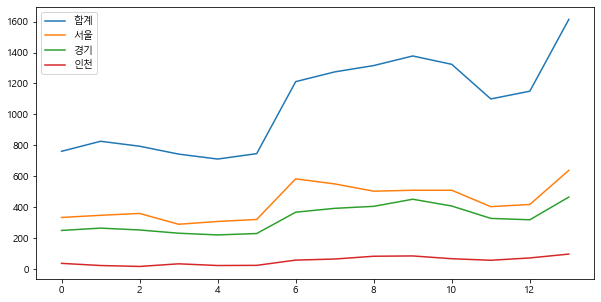

In [62]:
df2 = df0[['합계','서울','경기','인천']]

df2.plot(figsize = (10,5))
plt.show()